## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
from tensorflow.python import keras
import itertools
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\Hero3C\Anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Hero3C\Anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Hero3C\Anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Hero3C\Anaconda3\envs\keras\lib\site-packages\tensorflow\pyth

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.regularizers import l1, l2, l1_l2
from tensorflow.python.keras.layers import Dropout

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4, drp_ratio=0.05):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
       

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-2
EPOCHS = 50
BATCH_SIZE = [128, 256, 1024]
MOMENTUM = 0.95
Dropout_EXP = [5e-2, 15e-2, 2e-1, 25e-2, 3e-1]
l2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for BATCH_S in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with BATCH_SIZE = %.3f" % (BATCH_S))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    #optimizer = keras.optimizers.Adam(lr=LEARNING_RATE, epsilon=None, decay=0.0) 
    #optimizer = keras.optimizers.RMSprop(lr=lr, epsilon=None, decay=0.0)
    #optimizer = keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=0.0)
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_S, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "BATCH_SIZE-%s" % str(BATCH_S)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with BATCH_SIZE = 128.000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)   

50000/50000 [==============================] - 8s 158us/sample - loss: 0.9366 - accuracy: 0.7249 - val_loss: 1.7633 - val_accuracy: 0.5004
Epoch 42/50
50000/50000 [==============================] - 8s 158us/sample - loss: 0.9241 - accuracy: 0.7290 - val_loss: 1.9550 - val_accuracy: 0.4654
Epoch 43/50
50000/50000 [==============================] - 8s 158us/sample - loss: 0.9161 - accuracy: 0.7341 - val_loss: 2.0630 - val_accuracy: 0.4568
Epoch 44/50
50000/50000 [==============================] - 8s 160us/sample - loss: 0.9134 - accuracy: 0.7351 - val_loss: 1.8808 - val_accuracy: 0.4781
Epoch 45/50
50000/50000 [==============================] - 8s 153us/sample - loss: 0.9076 - accuracy: 0.7374 - val_loss: 2.1674 - val_accuracy: 0.4456
Epoch 46/50
50000/50000 [==============================] - 8s 163us/sample - loss: 0.9169 - accuracy: 0.7343 - val_loss: 1.9849 - val_accuracy: 0.4484
Epoch 47/50
50000/50000 [==============================] - 7s 149us/sample - loss: 0.9057 - accuracy: 0.73

Epoch 34/50
50000/50000 [==============================] - 5s 102us/sample - loss: 0.8281 - accuracy: 0.7590 - val_loss: 1.9728 - val_accuracy: 0.4597
Epoch 35/50
50000/50000 [==============================] - 5s 99us/sample - loss: 0.8150 - accuracy: 0.7634 - val_loss: 2.2273 - val_accuracy: 0.4304
Epoch 36/50
50000/50000 [==============================] - 5s 104us/sample - loss: 0.8183 - accuracy: 0.7620 - val_loss: 1.9591 - val_accuracy: 0.4769
Epoch 37/50
50000/50000 [==============================] - 5s 103us/sample - loss: 0.8150 - accuracy: 0.7651 - val_loss: 2.1577 - val_accuracy: 0.4623
Epoch 38/50
50000/50000 [==============================] - 5s 102us/sample - loss: 0.7888 - accuracy: 0.7731 - val_loss: 2.1235 - val_accuracy: 0.4691
Epoch 39/50
50000/50000 [==============================] - 5s 102us/sample - loss: 0.7912 - accuracy: 0.7756 - val_loss: 2.1463 - val_accuracy: 0.4648
Epoch 40/50
50000/50000 [==============================] - 5s 108us/sample - loss: 0.7851 - acc

Epoch 27/50
50000/50000 [==============================] - 3s 63us/sample - loss: 0.7323 - accuracy: 0.7876 - val_loss: 1.9316 - val_accuracy: 0.4648
Epoch 28/50
50000/50000 [==============================] - 3s 63us/sample - loss: 0.7150 - accuracy: 0.7945 - val_loss: 2.0710 - val_accuracy: 0.4550
Epoch 29/50
50000/50000 [==============================] - 3s 64us/sample - loss: 0.6978 - accuracy: 0.8017 - val_loss: 2.2478 - val_accuracy: 0.4277
Epoch 30/50
50000/50000 [==============================] - 3s 64us/sample - loss: 0.6793 - accuracy: 0.8080 - val_loss: 2.1963 - val_accuracy: 0.4328
Epoch 31/50
50000/50000 [==============================] - 3s 63us/sample - loss: 0.6563 - accuracy: 0.8162 - val_loss: 2.0480 - val_accuracy: 0.4688
Epoch 32/50
50000/50000 [==============================] - 3s 63us/sample - loss: 0.6449 - accuracy: 0.8214 - val_loss: 2.0545 - val_accuracy: 0.4769
Epoch 33/50
50000/50000 [==============================] - 3s 61us/sample - loss: 0.6226 - accuracy:

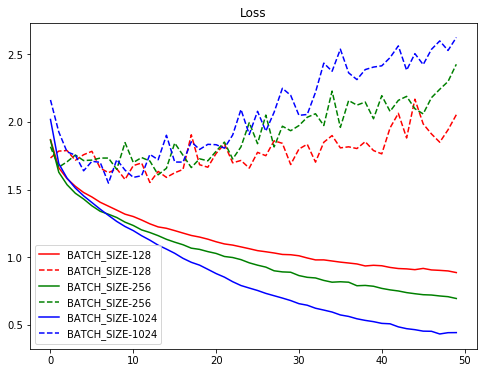

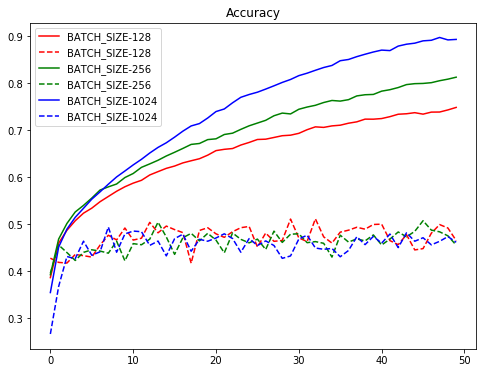

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()